# **Cheminformatics in Python: Predicting Solubility of Molecules**

Jesica Allende

[*LinkedIn Profile*](https://iplogger.com/2hKMx4),  [*GitHub*](https://iplogger.com/22A9e6).

Here, we will explore the field of Chemoinformatics, which combines Computer Science and Chemistry. Our focus is on replicating a research paper (Delaney, J.S.$^1$) that utilizes linear regression to forecast molecular solubility.

Understanding drug solubility is crucial in drug discovery, design, and development.

This notebook takes inspiration from a noteworthy blog post by Pat Walters$^2$, who achieved a comparable level of performance to Delaney's regression model.

This example is also briefly described in the book ***Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More***.$^3$

## **1. Install rdkit**

In [11]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2023-07-15 21:11:44--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.2’

Miniconda3-py37_4.8 100%[===================>]  81.12M   184MB/s    in 0.4s    

2023-07-15 21:11:44 (184 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.2’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b

## **2. Delaney's solubility dataset**

The original [Delaney's dataset](https://pubs.acs.org/doi/10.1021/ci034243x) available as a [Supplementary file](https://pubs.acs.org/doi/10.1021/ci034243x)$^4$. The full paper is entitled [ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x).$^1$

### **2.1. Download the dataset**

In [12]:
! wget https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt

--2023-07-15 21:12:30--  https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt
Resolving pubs.acs.org (pubs.acs.org)... 104.18.2.147, 104.18.3.147
Connecting to pubs.acs.org (pubs.acs.org)|104.18.2.147|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-07-15 21:12:31 ERROR 403: Forbidden.



In [13]:
! wget https://github.com/JesicaAllende/CB-Bio/blob/main/delaney_solubility.csv

--2023-07-15 21:12:31--  https://github.com/JesicaAllende/CB-Bio/blob/main/delaney_solubility.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74669 (73K) [text/plain]
Saving to: ‘delaney_solubility.csv.3’

delaney_solubility. 100%[===================>]  72.92K  --.-KB/s    in 0.05s   

2023-07-15 21:12:31 (1.44 MB/s) - ‘delaney_solubility.csv.3’ saved [74669/74669]



### **2.2. Read in the dataset**

In [14]:
import pandas as pd

In [15]:
sol = pd.read_csv('delaney_solubility.csv')
sol

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


### **2.3. SMILES data exploration.**

**SMILES** (_Simplified Molecular-Input Line-Entry System_) is a text-based representation of chemical structures. It simplifies complex molecular structures into a concise string format, enabling easy storage, retrieval, and manipulation of chemical information.

In [16]:
sol.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

The first element from the **SMILES** column of the **sol** dataframe.

In [17]:
sol.SMILES[0]

'ClCC(Cl)(Cl)Cl'

### **2.4. Convert a molecule from the SMILES string to an rdkit object**

In [18]:
!pip install rdkit

In [19]:
from rdkit import Chem

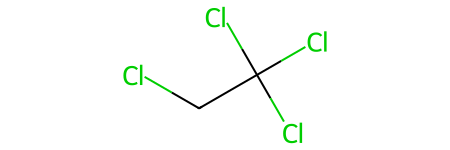

In [20]:
Chem.MolFromSmiles(sol.SMILES[0])

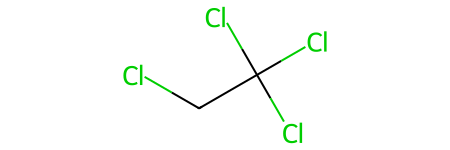

In [21]:
Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')

### **2.5. Working with rdkit object**

In [22]:
m = Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')

In [23]:
m.GetNumAtoms()

6

## **3. Calculate molecular descriptors in rdkit**

### **3.1. Convert list of molecules to rdkit object**

In [24]:
from rdkit import Chem

#### **3.1.1. Method 1**

In [25]:
mol_list= []
for element in sol.SMILES:
  mol = Chem.MolFromSmiles(element)
  mol_list.append(mol)

In [26]:
len(mol_list)

1144

In [27]:
mol_list[:5]

#### **3.1.2. Method 2**

In [28]:
mol_list2 = [Chem.MolFromSmiles(element) for element in sol.SMILES]

In [29]:
len(mol_list2)

1144

In [30]:
mol_list2[:5]

### **3.2. Calculate molecular descriptors**

To predict **LogS** (log of the aqueous solubility), the study by Delaney makes use of 4 molecular descriptors:
1. **cLogP** *(Octanol-water partition coefficient)*
2. **MW** *(Molecular weight)*
3. **RB** *(Number of rotatable bonds)*
4. **AP** *(Aromatic proportion = number of aromatic atoms / total number of heavy atoms)*

Unfortunately, rdkit readily computes the first 3. As for the AP descriptor, we will calculate this by manually computing the ratio of the *number of aromatic atoms* to the *total number of heavy atoms* which rdkit can compute.

#### **3.2.1. LogP, MW and RB**

In [31]:
import numpy as np
from rdkit.Chem import Descriptors

In [32]:
def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)

        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MolLogP","MolWt","NumRotatableBonds"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [33]:
df = generate(sol.SMILES)
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


#### **3.2.2. Aromatic proportion**

##### 3.2.1.1. Number of aromatic atoms

Here, we will create a custom function to calculate the **Number of aromatic atoms**. With this descriptor we can use it to subsequently calculate the AP descriptor.

Computing for a single molecule.

In [34]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')

In [35]:
aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
aromatic_atoms

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True]

In [36]:
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

In [37]:
AromaticAtoms(m)

19

Computing for molecules in the entire dataset.

In [38]:
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
desc_AromaticAtoms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 10,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 10,
 6,
 0,
 10,
 0,
 14,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 12,
 10,
 14,
 6,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 0,
 12,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 6,
 6,
 12,
 12,
 6,
 0,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 10,
 0,
 6,
 12,
 12,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 12,
 12,
 6,
 10,
 6,
 6,
 6,
 12,
 10,
 14,
 10,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 12,
 0,
 10,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,

##### 3.2.1.2. **Number of heavy atoms**

Here, we will use an existing function for calculating the Number of heavy atoms.

Computing for a single molecule.

In [39]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
Descriptors.HeavyAtomCount(m)

34

Computing for molecules in the entire dataset.

In [40]:
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_HeavyAtomCount

[6,
 5,
 6,
 5,
 8,
 4,
 4,
 8,
 10,
 10,
 10,
 9,
 9,
 10,
 10,
 10,
 9,
 9,
 9,
 8,
 8,
 4,
 8,
 4,
 5,
 8,
 8,
 10,
 12,
 4,
 9,
 9,
 9,
 15,
 8,
 4,
 8,
 8,
 5,
 8,
 8,
 12,
 12,
 8,
 6,
 8,
 8,
 10,
 8,
 12,
 12,
 5,
 12,
 6,
 14,
 11,
 22,
 15,
 5,
 5,
 8,
 7,
 11,
 9,
 6,
 4,
 5,
 4,
 4,
 4,
 5,
 5,
 8,
 7,
 11,
 6,
 4,
 11,
 10,
 13,
 12,
 8,
 7,
 7,
 17,
 7,
 6,
 7,
 6,
 5,
 8,
 11,
 4,
 7,
 14,
 11,
 15,
 9,
 11,
 11,
 13,
 6,
 10,
 9,
 9,
 19,
 9,
 8,
 8,
 16,
 6,
 5,
 5,
 9,
 4,
 15,
 22,
 20,
 18,
 20,
 18,
 16,
 19,
 19,
 18,
 17,
 17,
 18,
 16,
 7,
 18,
 18,
 16,
 17,
 8,
 9,
 16,
 7,
 6,
 7,
 8,
 6,
 14,
 18,
 19,
 18,
 17,
 17,
 16,
 11,
 11,
 15,
 15,
 10,
 8,
 11,
 15,
 10,
 10,
 11,
 9,
 6,
 6,
 12,
 7,
 8,
 15,
 15,
 10,
 15,
 10,
 10,
 16,
 9,
 8,
 8,
 8,
 7,
 9,
 8,
 13,
 14,
 14,
 9,
 12,
 9,
 8,
 13,
 14,
 12,
 15,
 11,
 11,
 4,
 8,
 5,
 5,
 8,
 6,
 9,
 13,
 5,
 11,
 8,
 4,
 8,
 6,
 11,
 8,
 7,
 9,
 9,
 7,
 9,
 12,
 9,
 8,
 8,
 7,
 7,
 11,
 7,
 4,
 10,
 12,
 5,

##### **3.2.1.3. Computing the Aromatic Proportion (AP) descriptor**

Computing for a single molecule.

In [41]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
AromaticAtoms(m)/Descriptors.HeavyAtomCount(m)

0.5588235294117647

Computing for molecules in the entire dataset.

In [42]:
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_AromaticProportion

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.75,
 0.75,
 0.0,
 0.75,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.5,
 0.0,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.4,
 0.75,
 0.0,
 0.75,
 0.75,
 0.0,
 0.0,
 0.75,
 0.8333333333333334,
 0.5,
 0.75,
 0.0,
 0.75,
 0.75,
 0.6,
 0.75,
 0.8333333333333334,
 0.5,
 0.0,
 0.8333333333333334,
 0.0,
 1.0,
 0.0,
 0.0,
 0.9333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.8571428571428571,
 0.9090909090909091,
 0.9333333333333333,
 0.6666666666666666,
 0.9090909090909091,
 0.9090909090909091,
 0.7692307692307693,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

In [43]:
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion, columns=['AromaticProportion'])
df_desc_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


### **3.3. X matrix (Combining all computed descriptors into 1 dataframe)**

In [44]:
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


In [45]:
df_desc_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


Let's combine the 2 dataframes to produce the **X** matrix

In [46]:
X = pd.concat([df,df_desc_AromaticProportion], axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


### **3.4. Y matrix**

In [47]:
sol.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


Assigning the second column (index 1) to the Y matrix

In [48]:
Y = sol.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

---

## **Data split**

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## **Linear Regression Model**

In [51]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [52]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

### **Predicts the X_train**

In [53]:
Y_pred_train = model.predict(X_train)

In [54]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [-0.75392148 -0.00661464  0.00516706 -0.32842935]
Intercept: 0.27063542181528843
Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77


### **Predicts the X_test**

In [55]:
Y_pred_test = model.predict(X_test)

In [56]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Coefficients: [-0.75392148 -0.00661464  0.00516706 -0.32842935]
Intercept: 0.27063542181528843
Mean squared error (MSE): 1.03
Coefficient of determination (R^2): 0.76


### **Linear Regression Equation**

The work of Delaney$^1$ provided the following linear regression equation:

> LogS = 0.16 -  0.63 cLogP - 0.0062 MW + 0.066 RB - 0.74 AP

The reproduction by Pat Walters$^2$ provided the following:

> LogS = 0.26 -  0.74 LogP - 0.0066 MW + 0.0034 RB - 0.42 AP

This notebook's reproduction gave the following equation:

* Based on the Train set
> LogS = 0.2753 -0.7503 LogP - 0.0065 MW -0.0060 RB - 0.4252 AP

* Based on the Full dataset
> LogS = 0.2753 -0.7503 LogP - 0.0065 MW -0.0060 RB - 0.4252 AP

#### **Our linear regression equation**

In [57]:
print('LogS = %.2f %.2f LogP %.4f MW %.4f RB %.2f AP' % (model.intercept_, model.coef_[0], model.coef_[1], model.coef_[2], model.coef_[3] ) )

LogS = 0.27 -0.75 LogP -0.0066 MW 0.0052 RB -0.33 AP


The same equation can also be produced with the following code (which breaks up the previous one-line code into several comprehensible lines.

In [58]:
yintercept = '%.2f' % model.intercept_
LogP = '%.2f LogP' % model.coef_[0]
MW = '%.4f MW' % model.coef_[1]
RB = '%.4f RB' % model.coef_[2]
AP = '%.2f AP' % model.coef_[3]

In [59]:
print('LogS = ' +
      ' ' +
      yintercept +
      ' ' +
      LogP +
      ' ' +
      MW +
      ' ' +
      RB +
      ' ' +
      AP)

LogS =  0.27 -0.75 LogP -0.0066 MW 0.0052 RB -0.33 AP


#### **Use entire dataset for model training (For Comparison)**

In [60]:
full = linear_model.LinearRegression()
full.fit(X, Y)

LinearRegression()

In [61]:
full_pred = model.predict(X)

In [62]:
print('Coefficients:', full.coef_)
print('Intercept:', full.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y, full_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y, full_pred))

Coefficients: [-0.74173609 -0.00659927  0.00320051 -0.42316387]
Intercept: 0.2565006830997185
Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77


In [63]:
full_yintercept = '%.2f' % full.intercept_
full_LogP = '%.2f LogP' % full.coef_[0]
full_MW = '%.4f MW' % full.coef_[1]
full_RB = '+ %.4f RB' % full.coef_[2]
full_AP = '%.2f AP' % full.coef_[3]

In [64]:
print('LogS = ' +
      ' ' +
      full_yintercept +
      ' ' +
      full_LogP +
      ' ' +
      full_MW +
      ' ' +
      full_RB +
      ' ' +
      full_AP)

LogS =  0.26 -0.74 LogP -0.0066 MW + 0.0032 RB -0.42 AP


## **Scatter plot of experimental vs. predicted LogS**

In [65]:
import matplotlib.pyplot as plt

### **Quick check of the variable dimensions of Train and Test sets**

In [66]:
Y_train.shape, Y_pred_train.shape

((915,), (915,))

In [67]:
Y_test.shape, Y_pred_test.shape

((229,), (229,))

### **Vertical plot**

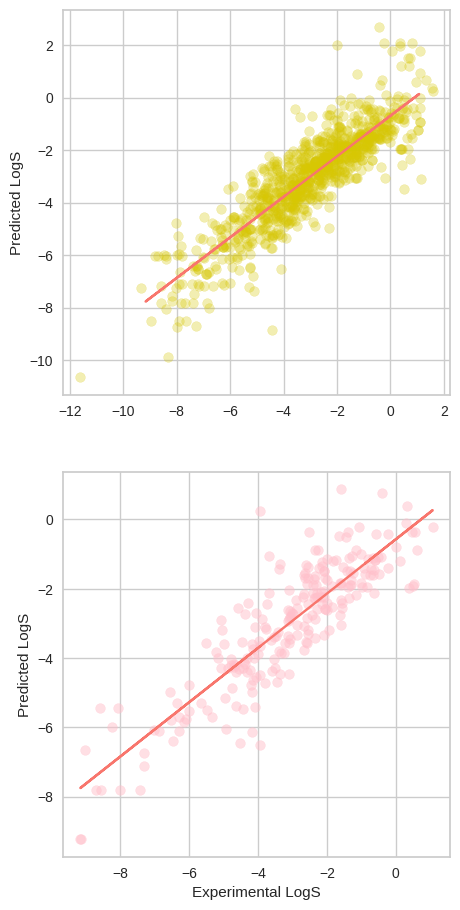

In [68]:
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="y", alpha=0.3)

# Add trendline
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="pink", alpha=0.5)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.savefig('plot_vertical_logS.png')
plt.savefig('plot_vertical_logS.pdf')
plt.show()

### **Horizontal plot**

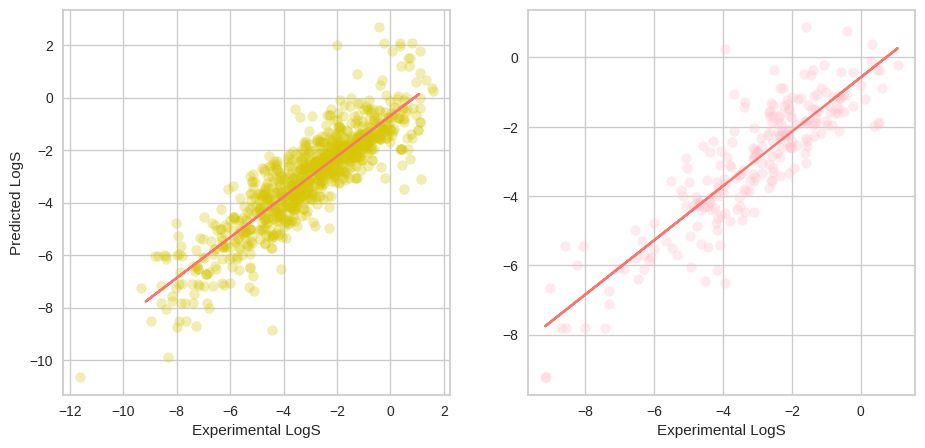

In [69]:
plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="y", alpha=0.3)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="pink", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS')

plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()

##**Aromatic proportion descriptor**

In [70]:
def AromaticProportion(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  AromaticAtom = sum(aa_count)
  HeavyAtom = Descriptors.HeavyAtomCount(m)
  AR = AromaticAtom/HeavyAtom
  return AR

In [71]:
def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
        desc_AromaticProportion = AromaticProportion(mol)

        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds,
                        desc_AromaticProportion])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MolLogP","MolWt","NumRotatableBonds","AromaticProportion"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

##**4. Preparing the X and Y Data Matrices**
4.1. X matrix (the computed descriptors)


In [72]:
x = generate(sol.SMILES)
x

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


4.2. Y matrix

In [73]:
#Assigning the second column (index 1) to the Y matrix
Y = sol.iloc[:,1]
Y = Y.rename("logS")
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: logS, Length: 1144, dtype: float64

<Axes: >

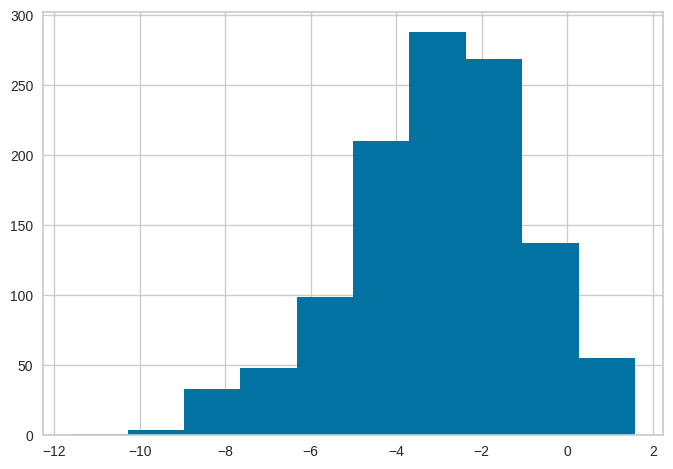

In [74]:
Y.hist()

4.3. Combine X and Y into same dataframe

In [75]:
dataset = pd.concat([X,Y], axis=1)
dataset

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
0,2.59540,167.850,0.0,0.000000,-2.180
1,2.37650,133.405,0.0,0.000000,-2.000
2,2.59380,167.850,1.0,0.000000,-1.740
3,2.02890,133.405,1.0,0.000000,-1.480
4,2.91890,187.375,1.0,0.000000,-3.040
...,...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000,1.144
1140,3.42130,286.114,2.0,0.333333,-4.925
1141,3.60960,308.333,4.0,0.695652,-3.893
1142,2.56214,354.815,3.0,0.521739,-3.790


In [106]:
dataset.to_csv('delaney_solubility_with_descriptors.csv', index=False)

#**5. Solubility prediction with PyCaret | ML**

5.1. Install PyCaret

In [77]:
! pip install pycaret

  Using cached pycaret-3.0.4-py3-none-any.whl (484 kB)
  Using cached importlib_metadata-6.7.0-py3-none-any.whl (22 kB)
  Using cached ipywidgets-8.0.7-py3-none-any.whl (138 kB)
  Using cached pmdarima-2.0.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (1.8 MB)
  Using cached schemdraw-0.15-py3-none-any.whl (106 kB)
  Using cached statsmodels-0.13.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.9 MB)
  Using cached yellowbrick-1.5-py3-none-any.whl (282 kB)
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached pyod-1.1.0.tar.gz (153 kB)
  Using cached category_encoders-2.6.1-py2.py3-none-any.whl (81 kB)
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached nbformat-5.8.0-py3-none-any.whl (77 kB)
  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_

In [78]:
#Model Setup
from pycaret.regression import *

5.2. Read in dataset

In [79]:
delaney_solubility_with_descriptors_url = 'https://raw.githubusercontent.com/JesicaAllende/CB-Bio/main/delaney_solubility_with_descriptors.csv'
dataset = pd.read_csv(delaney_solubility_with_descriptors_url)

In [80]:
dataset

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
0,2.59540,167.850,0.0,0.000000,-2.180
1,2.37650,133.405,0.0,0.000000,-2.000
2,2.59380,167.850,1.0,0.000000,-1.740
3,2.02890,133.405,1.0,0.000000,-1.480
4,2.91890,187.375,1.0,0.000000,-3.040
...,...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000,1.144
1140,3.42130,286.114,2.0,0.333333,-4.925
1141,3.60960,308.333,4.0,0.695652,-3.893
1142,2.56214,354.815,3.0,0.521739,-3.790


5.3. Model Building

In [81]:
model = setup(data = dataset, target = 'logS', train_size=0.85) #we use the 85% of the subset (train_size) for model building.

,Description,Value
0,Session id,7971
1,Target,logS
2,Target type,Regression
3,Original data shape,"(1144, 5)"
4,Transformed data shape,"(1144, 5)"
5,Transformed train set shape,"(972, 5)"
6,Transformed test set shape,"(172, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


5.4. Model comparison

In [82]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.5076,0.5116,0.7117,0.8784,0.2042,0.6666,0.5800
rf,Random Forest Regressor,0.5185,0.5387,0.7297,0.8723,0.2063,0.6989,1.3500
lightgbm,Light Gradient Boosting Machine,0.5438,0.5738,0.7543,0.8649,0.2155,0.6834,0.3750
gbr,Gradient Boosting Regressor,0.5854,0.6015,0.7707,0.8570,0.2234,0.7078,0.6130
xgboost,Extreme Gradient Boosting,0.5539,0.6040,0.7744,0.8563,0.2220,0.7185,0.3010
ada,AdaBoost Regressor,0.6959,0.7923,0.8872,0.8126,0.2389,0.8770,0.5540
dt,Decision Tree Regressor,0.6761,0.9228,0.9579,0.7786,0.2584,0.8148,0.3720
br,Bayesian Ridge,0.7722,1.0060,0.9990,0.7575,0.2831,0.9415,0.3460
lar,Least Angle Regression,0.7715,1.0062,0.9991,0.7574,0.2833,0.9405,0.2240
ridge,Ridge Regression,0.7716,1.0061,0.9991,0.7574,0.2833,0.9407,0.4910


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

ExtraTreesRegressor(n_jobs=-1, random_state=7971)

5.5. Model Creation

In [83]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4534,0.3908,0.6252,0.8804,0.1837,0.3889
1,0.4976,0.4736,0.6882,0.8867,0.1796,0.2402
2,0.5003,0.4463,0.6680,0.9072,0.1884,0.7487
3,0.5415,0.5485,0.7406,0.8515,0.2519,0.4696
4,0.4981,0.4460,0.6678,0.9209,0.1825,0.2997
5,0.4933,0.4171,0.6459,0.9065,0.1802,0.2019
6,0.5510,0.7114,0.8434,0.8492,0.2372,0.6025
7,0.4613,0.4358,0.6601,0.8995,0.1776,0.3775
8,0.5367,0.5734,0.7572,0.8536,0.2368,2.3332


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

5.6. Model Tuning

Here, the learning parameters undergo optimization. The optimization process involves 50 iterations, and the fitness function used to assess the optimal learning parameter settings is the Mean Absolute Error (MAE).

In [85]:
# Tune the model
tuned_et = tune_model(et, n_iter=50, optimize='mae')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5250,0.4725,0.6874,0.8554,0.1819,0.4325
1,0.5139,0.4774,0.6909,0.8858,0.1801,0.2508
2,0.5307,0.4603,0.6784,0.9043,0.1705,0.4767
3,0.5526,0.4769,0.6906,0.8708,0.2263,0.5251
4,0.5756,0.6109,0.7816,0.8916,0.2144,0.3533
5,0.5270,0.4284,0.6545,0.9039,0.1736,0.2442
6,0.6552,0.8620,0.9285,0.8173,0.2785,0.7550
7,0.5389,0.4800,0.6928,0.8893,0.1924,0.7028
8,0.6060,0.6301,0.7938,0.8391,0.2345,2.2428


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [86]:
print(tuned_et)

ExtraTreesRegressor(n_jobs=-1, random_state=7971)


###**5.7. Model Analysis**

Plot Models

Residuals Plot

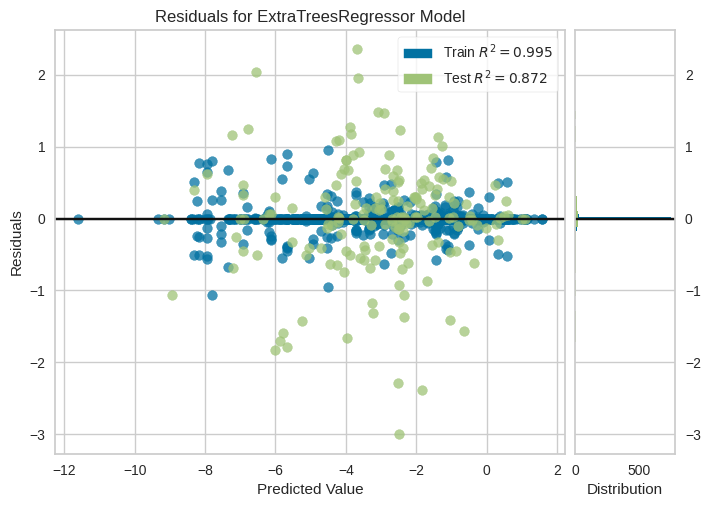

In [87]:
plot_model(et, 'residuals')

Prediction Error Plot

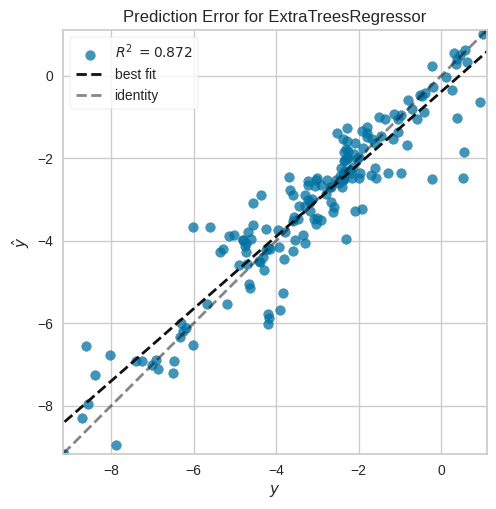

In [88]:
plot_model(et, 'error')

Cooks Distance Plot

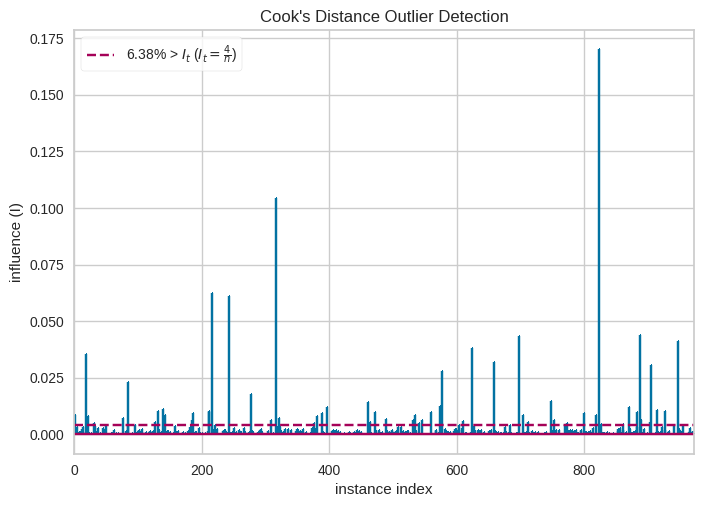

In [89]:
plot_model(et, 'cooks')

Recursive Feature Selection

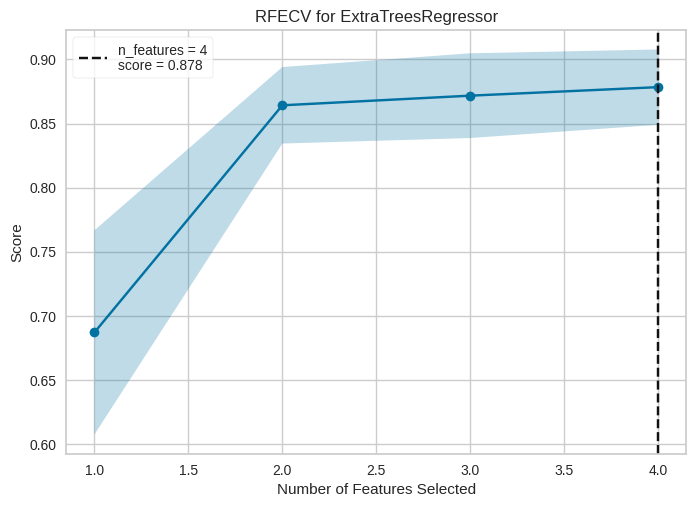

In [90]:
plot_model(et, 'rfe')

Learning Curve

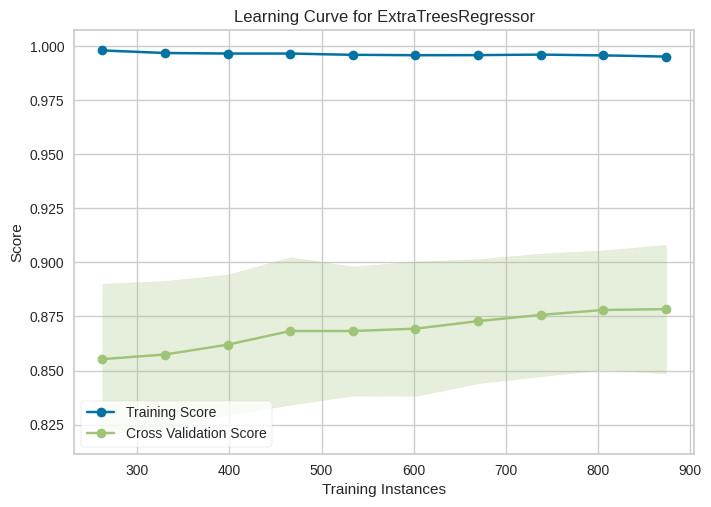

In [91]:
plot_model(et, 'learning')

Validation Curve

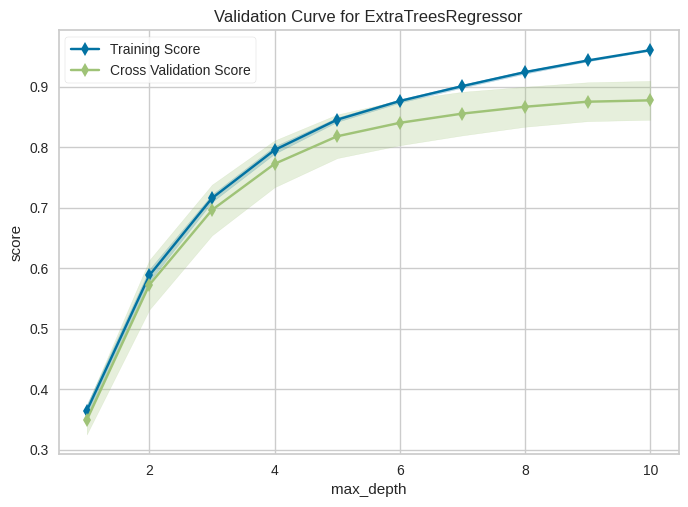

In [92]:
plot_model(et, 'vc')

Manifold Learning

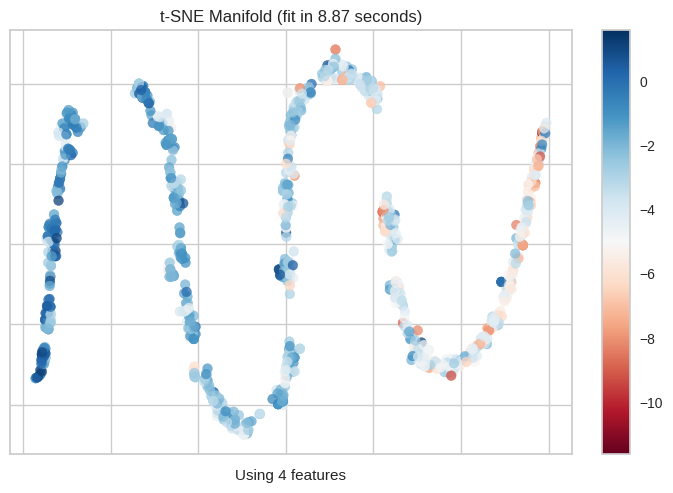

In [93]:
plot_model(et, 'manifold')

Feature Importance

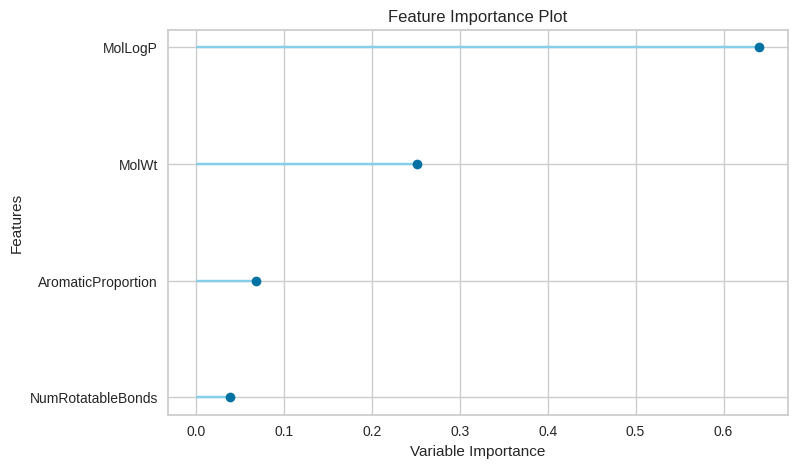

In [94]:
plot_model(et, 'feature')

Model Hyperparameter.

The hyperparameter of the learning model is displayed using the ``parameter`` argument in inside the ``plot_model()`` function.

In [95]:
plot_model(et, 'parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,squared_error
max_depth,None
max_features,1.0
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2


Hyperparameter of the tuned model is shown below.

In [96]:
plot_model(tuned_et, 'parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,squared_error
max_depth,None
max_features,1.0
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2


**Show all plots**

In [97]:
evaluate_model(tuned_et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

###**5.8. External Testing**

Here, we will apply the trained model (built with 85% subset) to evaluate on the so-called **"hold-out"** testing set (the 20% subset) that serves as the unseen data.

In [99]:
prediction_holdout = predict_model(et)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.5285,0.5916,0.7692,0.8725,0.1957,0.3588


In [100]:
prediction_holdout.head()

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS,prediction_label
555,6.18790,318.029999,2.0,0.666667,-6.900,-6.900000
1037,3.43460,252.317001,1.0,0.631579,-4.749,-4.127180
669,1.56890,166.175995,2.0,0.500000,-2.350,-2.496907
54,2.78300,180.210007,0.0,1.000000,-2.680,-3.057233
271,1.69844,107.155998,0.0,0.750000,0.380,0.392500


In [101]:
! ls -l

total 253124
-rw-r--r-- 1 root root    58889 Jul 15 21:09 delaney_solubility.csv
-rw-r--r-- 1 root root    74668 Jul 15 19:59 delaney_solubility.csv.1
-rw-r--r-- 1 root root    74669 Jul 15 20:56 delaney_solubility.csv.2
-rw-r--r-- 1 root root    74669 Jul 15 21:12 delaney_solubility.csv.3
-rw-r--r-- 1 root root    56474 Jul 15 21:12 delaney_solubility_with_descriptors.csv
-rw-r--r-- 1 root root  3399683 Jul 15 21:26 logs.log
-rwxr-xr-x 1 root root 85055499 Mar 11  2020 Miniconda3-py37_4.8.2-Linux-x86_64.sh
-rw-r--r-- 1 root root 85055499 Mar 11  2020 Miniconda3-py37_4.8.2-Linux-x86_64.sh.1
-rw-r--r-- 1 root root 85055499 Mar 11  2020 Miniconda3-py37_4.8.2-Linux-x86_64.sh.2
-rw-r--r-- 1 root root    33198 Jul 15 21:12 plot_horizontal_logS.pdf
-rw-r--r-- 1 root root    87972 Jul 15 21:12 plot_horizontal_logS.png
-rw-r--r-- 1 root root    33243 Jul 15 21:12 plot_vertical_logS.pdf
-rw-r--r-- 1 root root    88563 Jul 15 21:12 plot_vertical_logS.png
drwxr-xr-x 1 root root     4096 Jul 13 13

---

## **Reference**

1. John S. Delaney. [ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x). **J. Chem. Inf. Comput. Sci.** 2004, 44, 3, 1000-1005.

2. Pat Walters. [Predicting Aqueous Solubility - It's Harder Than It Looks](http://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html). **Practical Cheminformatics Blog**

3. Bharath Ramsundar, Peter Eastman, Patrick Walters, and Vijay Pande. [Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More](https://learning.oreilly.com/library/view/deep-learning-for/9781492039822/), O'Reilly, 2019.

4. **[Supplementary file]**(https://pubs.acs.org/doi/10.1021/ci034243x) from Delaney's ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure.